# MAPS Framework Tutorial
## Model Agnostic Post-hoc Synthetic Data Refinement

This tutorial demonstrates how to use MAPS to improve synthetic data quality while ensuring re-identifiability protection through a two-stage approach:
1. **Stage 1**: Remove identifiable synthetic samples (0-identifiability guarantee)
2. **Stage 2**: Enhance fidelity through importance weighting and resampling


In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path for imports
sys.path.append(os.path.abspath('..'))

# Set CUDA device if available
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_blobs
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal

# Import MAPS components
from maps import FidelityClassifier, IdentifiabilityAnalyzer, SamplingEngine

# Set random seeds for reproducibility
np.random.seed(42)
plt.style.use('seaborn-v0_8')

print("MAPS Framework loaded successfully!")

MAPS Framework loaded successfully!


## Load the real data(from UCI dataset)

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 
  
# data (as pandas dataframes) 
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features 
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets 
  
# concatenate dataframes
real_data = pd.concat([X, y], axis=1)

## Generate the synthetic data (from Synthcity package)

In [4]:
from synthcity.plugins.core.dataloader import GenericDataLoader
from synthcity.plugins import Plugins

E0000 00:00:1758313005.297602 1232869 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758313005.319674 1232869 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [5]:
loader = GenericDataLoader(
    real_data,
    train_size=0.6,
    stratify='NObeyesdad'
)

In [6]:
syn_model = Plugins().get("tvae")

syn_model.fit(loader)

[2025-09-19T22:17:01.718087+0200][1232869][CRITICAL] load failed: Failed to import transformers.trainer because of the following error (look up to see its traceback):
Failed to import transformers.integrations.integration_utils because of the following error (look up to see its traceback):
Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.
[2025-09-19T22:17:01.720825+0200][1232869][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2025-09-19T22:17:01.721811+0200][1232869][CRITICAL] module plugin_great load failed
[2025-09-19T22:17:06.349452+0200][1232869][CRITICAL] module disabled: /home/tgj290/.venv/lib64/python3.11/site-packages/synthcity/plugins/generic/plugin_goggle.py
 40%|████      | 400/10

### Generate 10X synthetic data to form the synthetic data pool

In [7]:
synthetic_data_pool = syn_model.generate(count=real_data.shape[0]*30).dataframe()
synthetic_data = synthetic_data_pool

### Random sampling N from synthetic data pool to form baseline

In [8]:
rng = np.random.default_rng(seed=0)
random_indices = rng.choice(synthetic_data_pool.index, size=len(real_data), replace=False)
random_sampled_data = synthetic_data_pool.iloc[random_indices].reset_index(drop=True)
raw_synthetic_data = random_sampled_data.copy()

## Stage 1: remove all the identifiable synthetic samples (0-identifiability guaranteed)

In [21]:
identifiability_analyzer = IdentifiabilityAnalyzer()
identifiability_flags = identifiability_analyzer.fit(real_data, synthetic_data_pool)
# get the indices where identifiability_flags == 0
identifiability_indices = np.where(identifiability_flags == 0)[0]
# only keep identifiability_flags == 0 for synthetic_data and identifiability_flags
synthetic_data_non_identifiable = synthetic_data.iloc[identifiability_indices].reset_index(drop=True)
identifiability_flags = identifiability_flags[identifiability_indices]

STARTING IDENTIFIABILITY ANALYSIS

1. PREPROCESSING DATA FOR IDENTIFIABILITY ANALYSIS
----------------------------------------
Starting data preprocessing for identifiability analysis...
Real data shape: (2111, 17)
Synthetic data shape: (63330, 17)
Merging datasets to create consistent encoders...
Numerical: 8, Categorical: 4, Binary: 5
  Encoded binary column 'Gender': 2 categories
  Encoded binary column 'family_history_with_overweight': 2 categories
  Encoded binary column 'FAVC': 2 categories
  Encoded categorical column 'CAEC': 4 categories
  Encoded binary column 'SMOKE': 2 categories
  Encoded binary column 'SCC': 2 categories
  Encoded categorical column 'CALC': 4 categories
  Encoded categorical column 'MTRANS': 5 categories
  Encoded categorical column 'NObeyesdad': 7 categories
Preprocessing complete. Shape: (2111, 17)

2. COMPUTING FEATURE WEIGHTS
----------------------------------------
Computed feature weights for 17 features

3. CALCULATING REAL SAMPLE DISTINCTNESS THRES

## Stage 2: train a classifier using non-identifiable synthetic data

In [10]:
# randomly sample len(real_data) to train the classifier
training_size = 4*len(real_data)
synthetic_data_for_training = synthetic_data_non_identifiable.sample(n=training_size, random_state=42)
synthetic_data_for_evaluation = synthetic_data_non_identifiable.drop(synthetic_data_for_training.index).reset_index(drop=True)
synthetic_data_non_identifiable_for_evaluation = synthetic_data_for_evaluation

STARTING C-MAPS FIDELITY CLASSIFIER TRAINING
Real data for training: (2111, 17)
Synthetic data for training: (8444, 17)
Using embeddings for classifier: False

1. FITTING PREPROCESSOR ON FULL DATASETS
----------------------------------------
Starting data preprocessing for autoencoder...
Real data shape: (2111, 17)
Synthetic data shape: (8444, 17)
Identified 8 numerical, 4 categorical, 5 binary columns
Preprocessing complete. Shape: (2111, 33)

2. TRANSFORMING DATA
----------------------------------------
Processed real data shape: (2111, 33)
Processed synthetic training data shape: (8444, 33)
Note: Shapes should have same number of columns now

3. SKIPPING AUTOENCODER TRAINING (using processed data directly)
----------------------------------------

4. TRAINING CLASSIFIER FOR DENSITY RATIO ESTIMATION
----------------------------------------
Using processed data for classifier training: (2111, 33)
Training mlp classifier with sigmoid calibration
Test Accuracy: 0.8593
Test ROC AUC: 0.87

<Figure size 1000x700 with 0 Axes>

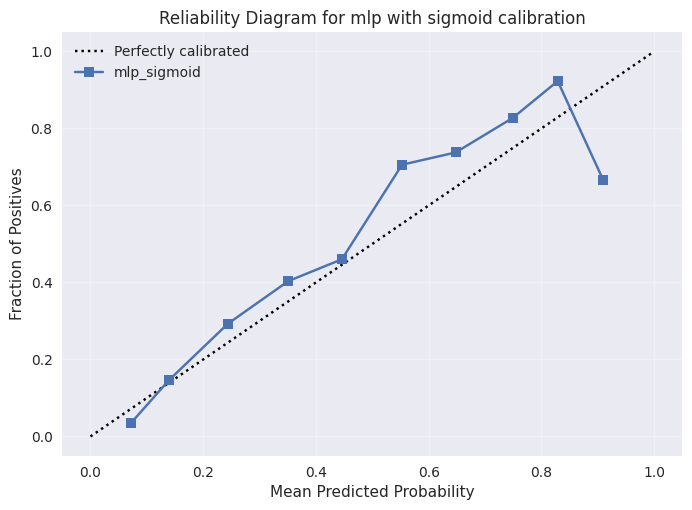


FIDELITY CLASSIFIER TRAINING COMPLETE!
Note: Use estimate_importance_weights(synthetic_data) with separate
synthetic data to avoid data leakage.
Estimating importance weights for 51016 synthetic samples
Using embeddings: False
Using processed data for importance weight estimation: (51016, 33)


In [11]:
fidelity_classifier = FidelityClassifier(classifier_type='mlp',calibration_method = 'sigmoid') # ('isotonic', 'sigmoid')
accuracy, roc_auc = fidelity_classifier.fit(real_data, synthetic_data_for_training,
                                            mlp_hidden_layer_sizes=(120,60),
                                            use_embedding = False,
                                            )
importance_weights, probs = fidelity_classifier.estimate_importance_weights(synthetic_data_non_identifiable_for_evaluation, use_embedding=False)

### Sampling to get N refined synthetic data

In [12]:
sampling_engine = SamplingEngine()
refined_data, weights, flags, indices, stats = sampling_engine.sample(
    synthetic_data=synthetic_data_non_identifiable_for_evaluation,
    importance_weights=importance_weights,
    n_samples=len(real_data),
    use_identifiability_constraint=False,
    identifiability_flags=identifiability_flags,
    epsilon_identifiability=0.00,  # Max 0% identifiable
    method='weighted',  # Options: 'top_k', 'weighted', 'reverse_weighted','reverse_top_k'
    weight_processing='flatten',  # Options: 'raw', 'flatten', 'clipped'
    alpha=1,                   # For flatten method: weights ** alpha
    # min_clip=1e-4                # For clipped method: max(weights, min_clip)
)
print(f"Refined {len(refined_data)} samples with {np.mean(flags):.2%} identifiable")
print(f"Weight processing: {stats['weight_processing']}, Identifiable: {stats['identifiable_percentage']:.2%}")
refined_synthetic_data = refined_data.copy()

Running SIR sampler to select 2111 samples using weighted method
Weight processing: flatten
  Alpha parameter: 1
  Original weights - Min: 0.243363, Max: 40.329930, Std: 1.833417, Mean: 0.914744
  Processed weights - Min: 0.243363, Max: 40.329930, Std: 1.833417, Mean: 0.914744
SIR sampling complete. Selected 2111 samples.
Weight statistics - Min: 0.2458, Max: 40.3299, Mean: 4.6073
Identifiable samples: 0/2111 (0.00%)
Refined 2111 samples with 0.00% identifiable
Weight processing: flatten, Identifiable: 0.00%


## Evaluation

### Visualize marginal distributions

In [13]:
import sys
sys.path.append(os.path.abspath('..'))
from maps.utils.ResultsVisualization import visualize_distributions

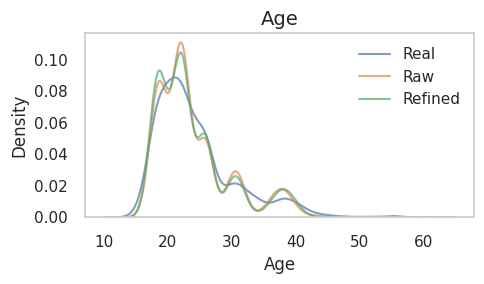

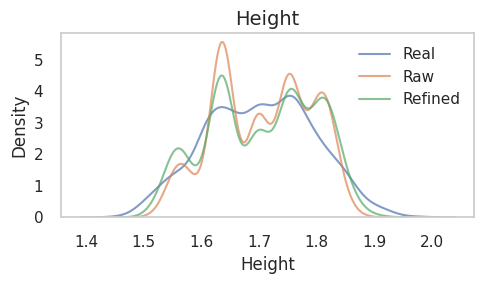

In [14]:
col = ['Age','Height']
fig = visualize_distributions(
    real_data=real_data,
    baseline_data=raw_synthetic_data,
    filtered_data=refined_synthetic_data,
    columns=col,
    figsize=(5, 3),
    separate_figures=True
)

### Quantify the marginal distribution similarity

In [15]:
from maps.utils.DistSimTest import evaluate_distribution_similarity

In [16]:
results_with_discretization = evaluate_distribution_similarity(
    real_data, raw_synthetic_data, refined_synthetic_data,
    discretize_numerical=True,
    mmd_kernel='rbf'
)

DISTRIBUTION SIMILARITY EVALUATION
Identified 8 numerical and 9 categorical columns
Numerical columns: ['Age', 'Height', 'FCVC', 'NCP', 'Weight']...
Categorical columns: ['NObeyesdad', 'Gender', 'SMOKE', 'CAEC', 'FAVC']...
Discretization enabled: Categorical metrics will include discretized numerical columns

Computing Jensen-Shannon Distance (Marginal)...
  Jensen-Shannon Distance (Marginal): Raw=0.180092, Refined=0.163135 ✓

Computing Jensen-Shannon Distance (Joint Categorical)...
  Jensen-Shannon Distance (Joint Categorical): Raw=0.470032, Refined=0.381080 ✓

Computing Inverse KL Divergence (Marginal)...
  Inverse KL Divergence (Marginal): Raw=0.723134, Refined=0.739047 ✓

Computing Chi-squared Test p-value (Marginal)...
  Chi-squared Test p-value (Marginal): Raw=0.451683, Refined=0.526703 ✓

Computing Total Variation Distance (Marginal)...
  Total Variation Distance (Marginal): Raw=0.182211, Refined=0.161869 ✓

Computing Kolmogorov-Smirnov Test (Marginal)...
  Kolmogorov-Smirnov Te

ASYMMETRIC MIXED CORRELATION ANALYSIS
Properly handling correlation ratio asymmetry with lower triangle display
Configuration: use_mixed=True, method=spearman
Categorical columns (9): ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']
Numerical columns (8): ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

Matrix Structure (Lower Triangle Only):
• Categorical-Categorical: Cramer's V (symmetric, red box)
• Categorical→Numerical: Correlation Ratio η² (asymmetric, green box)
• Numerical-Numerical: Correlation coefficient (symmetric, blue box)

ASYMMETRIC CORRELATION STRUCTURE ANALYSIS
---------------------------------------------
Categorical-Categorical (Cramer's V): range [0.01309200542100923, 0.5581938743788853], mean = 0.161
Categorical→Numerical (η²): range [4.8999196904983146e-05, 0.8486669323151147], mean = 0.050
Numerical-Numerical (spearman): range [-0.2980762907049495, 0.4625481443436106], mean = 0.072

SIM

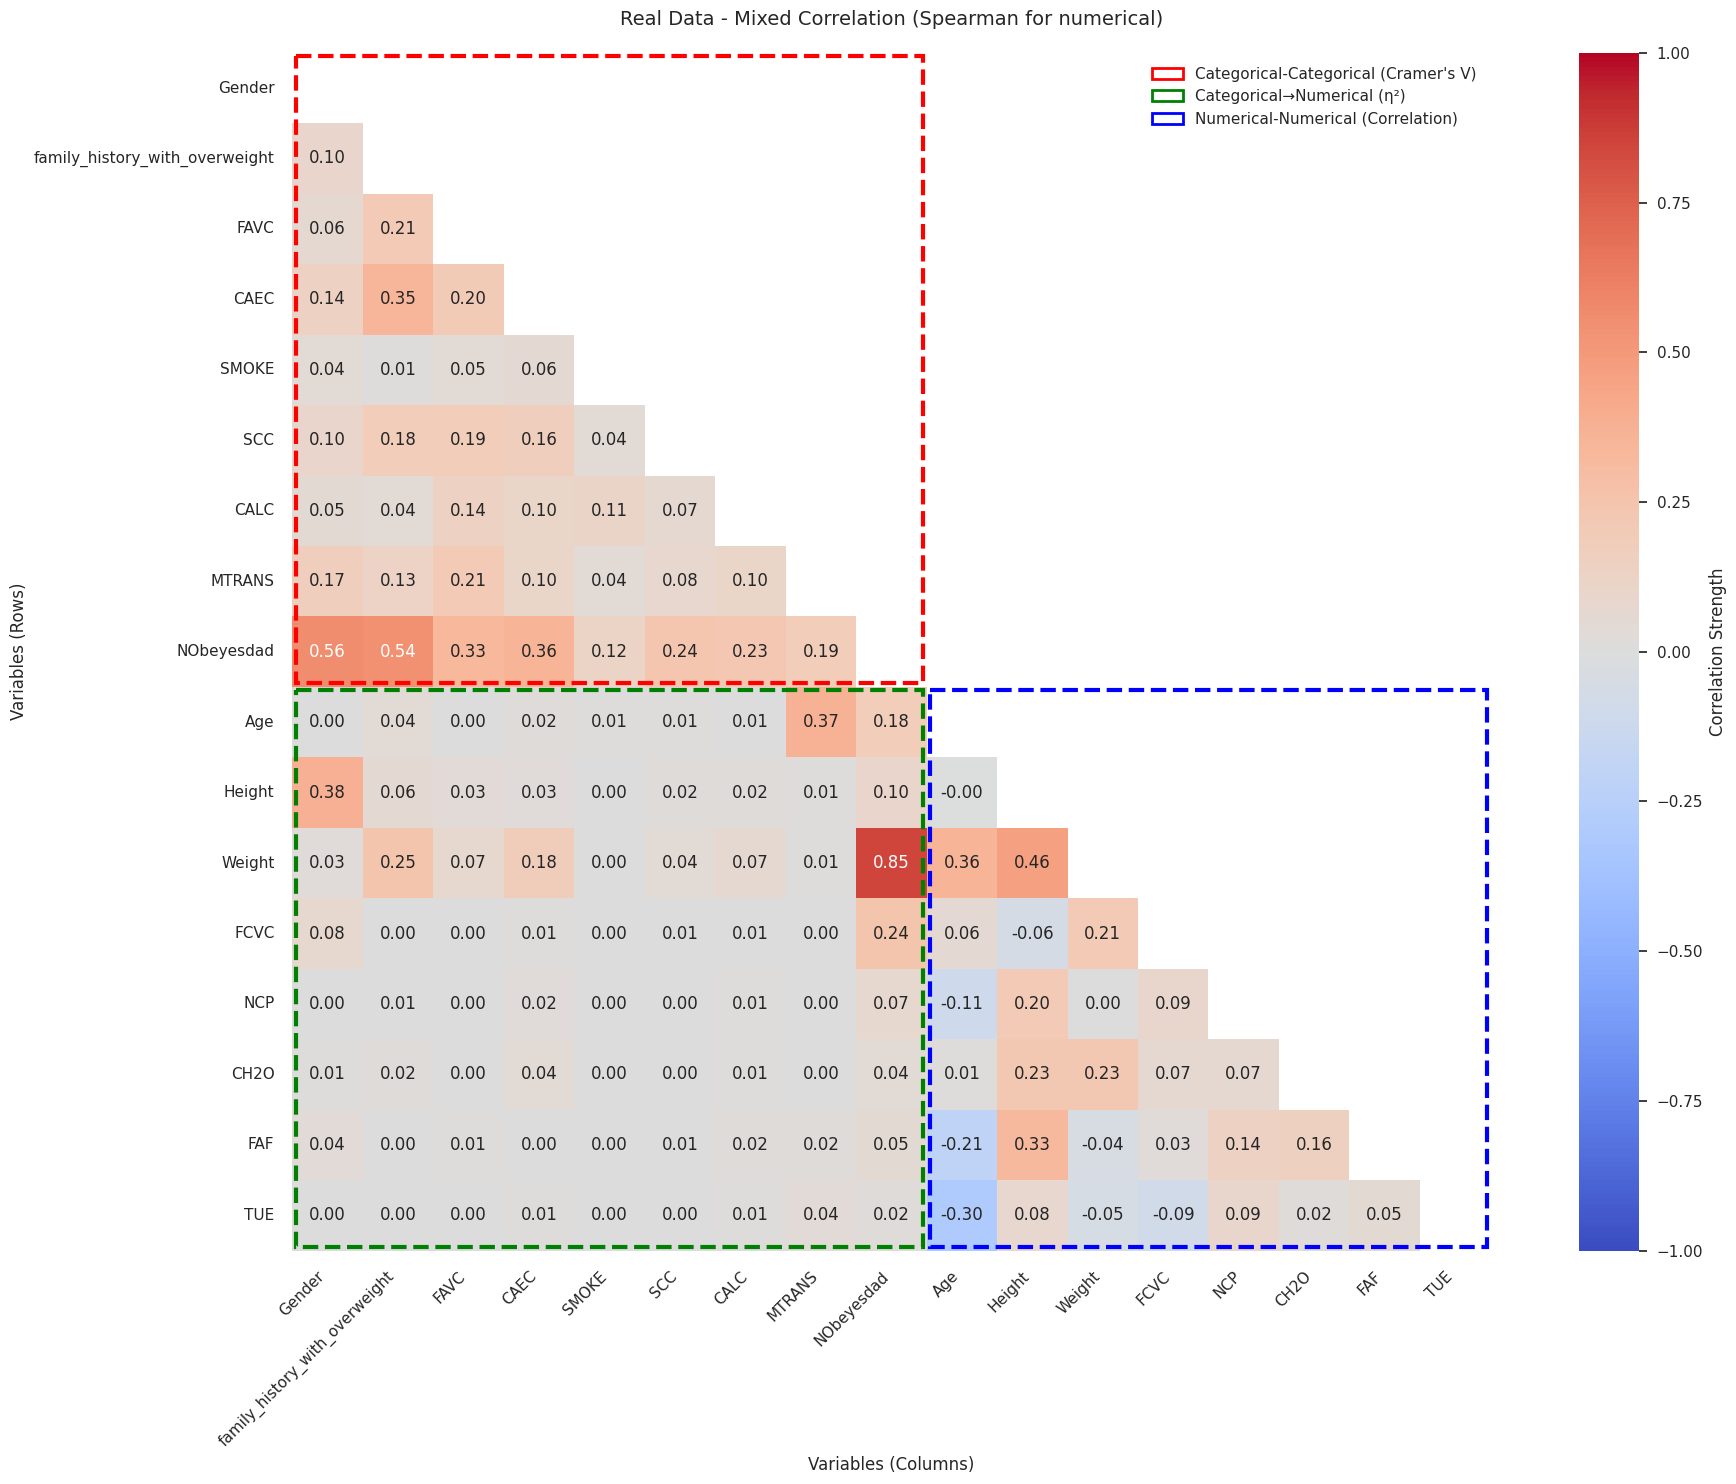

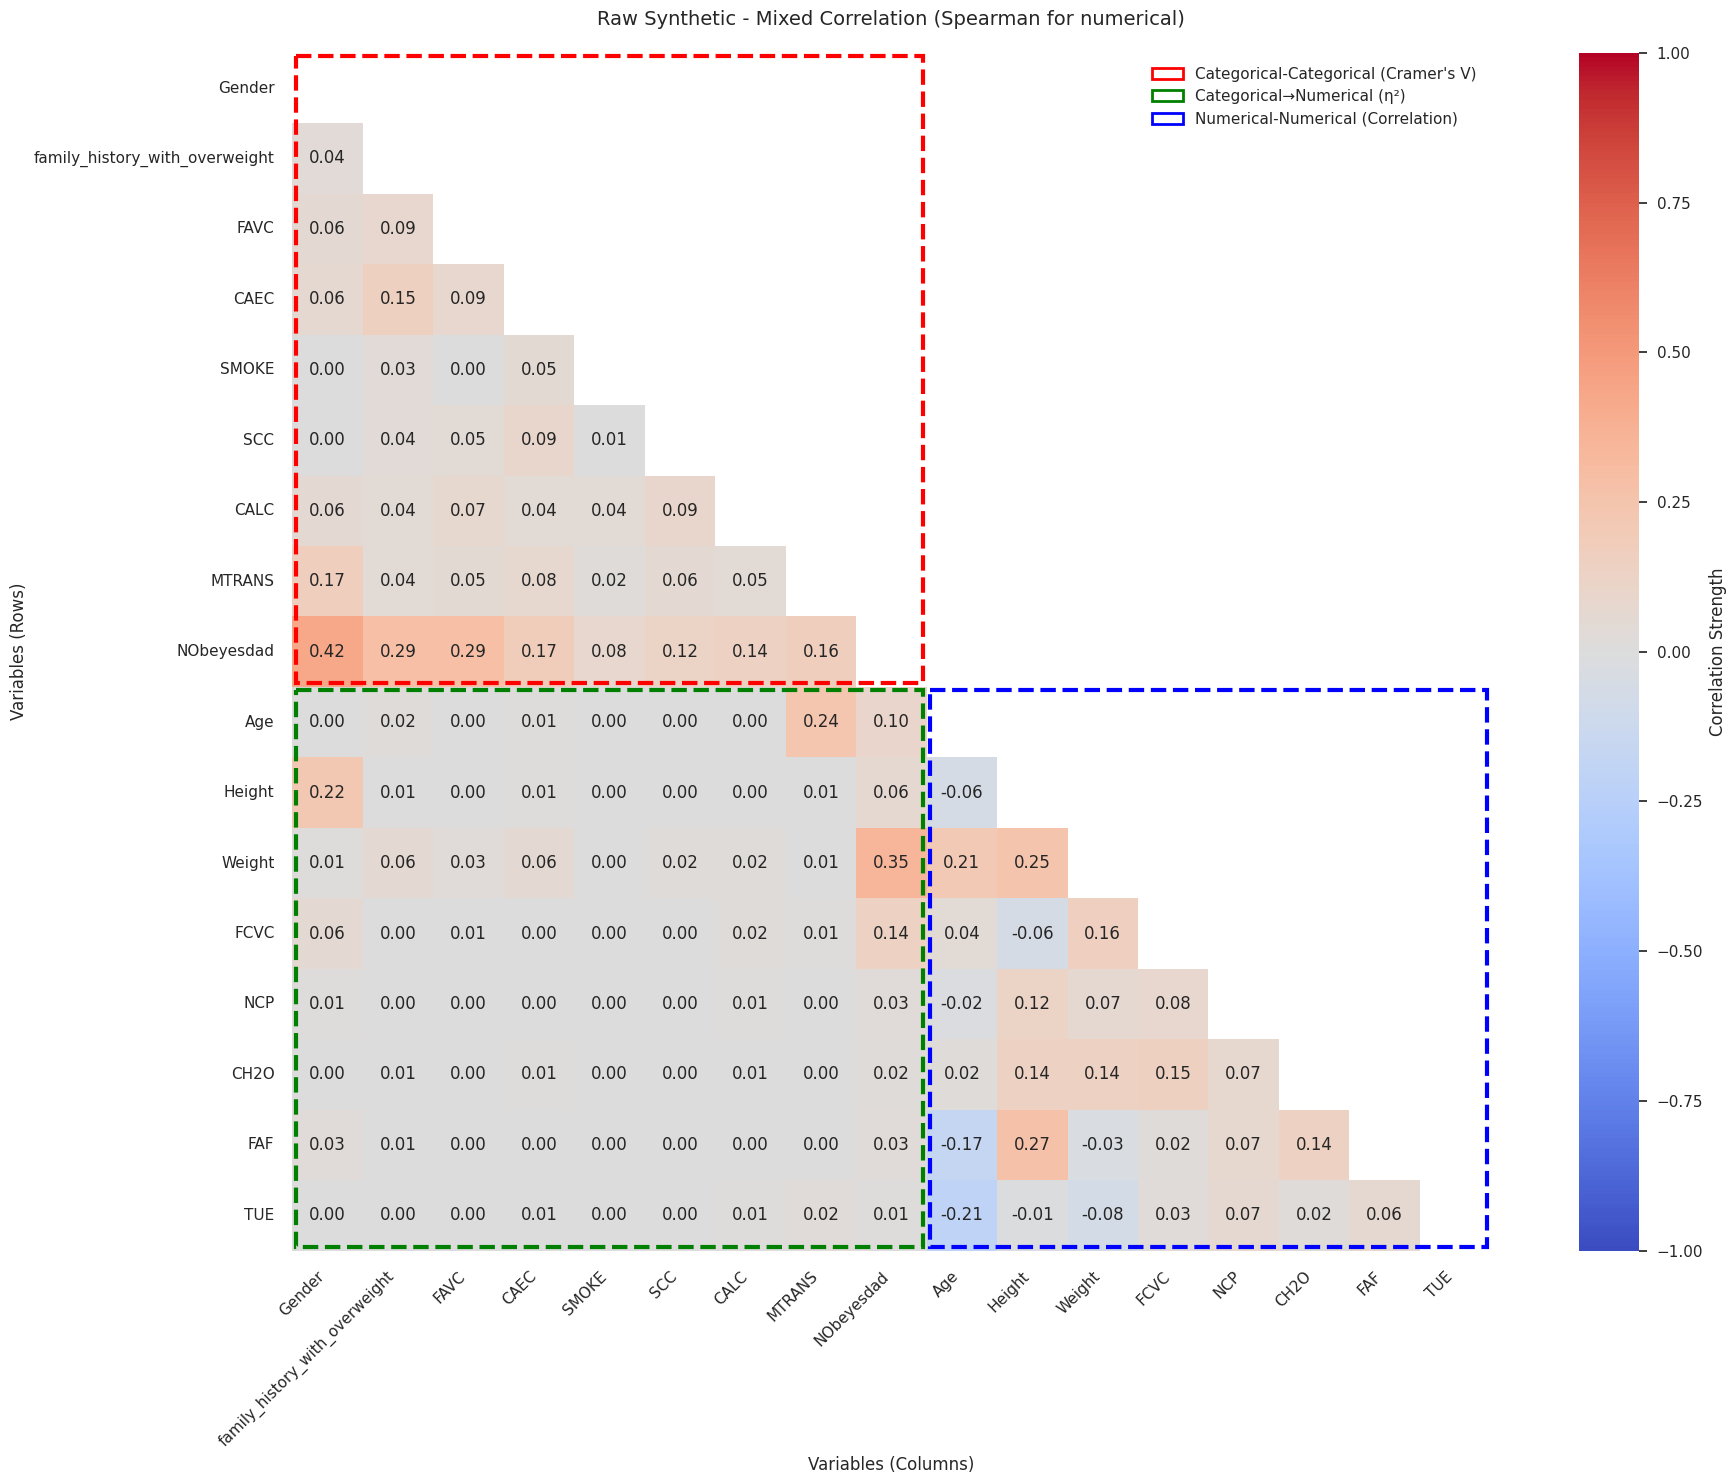

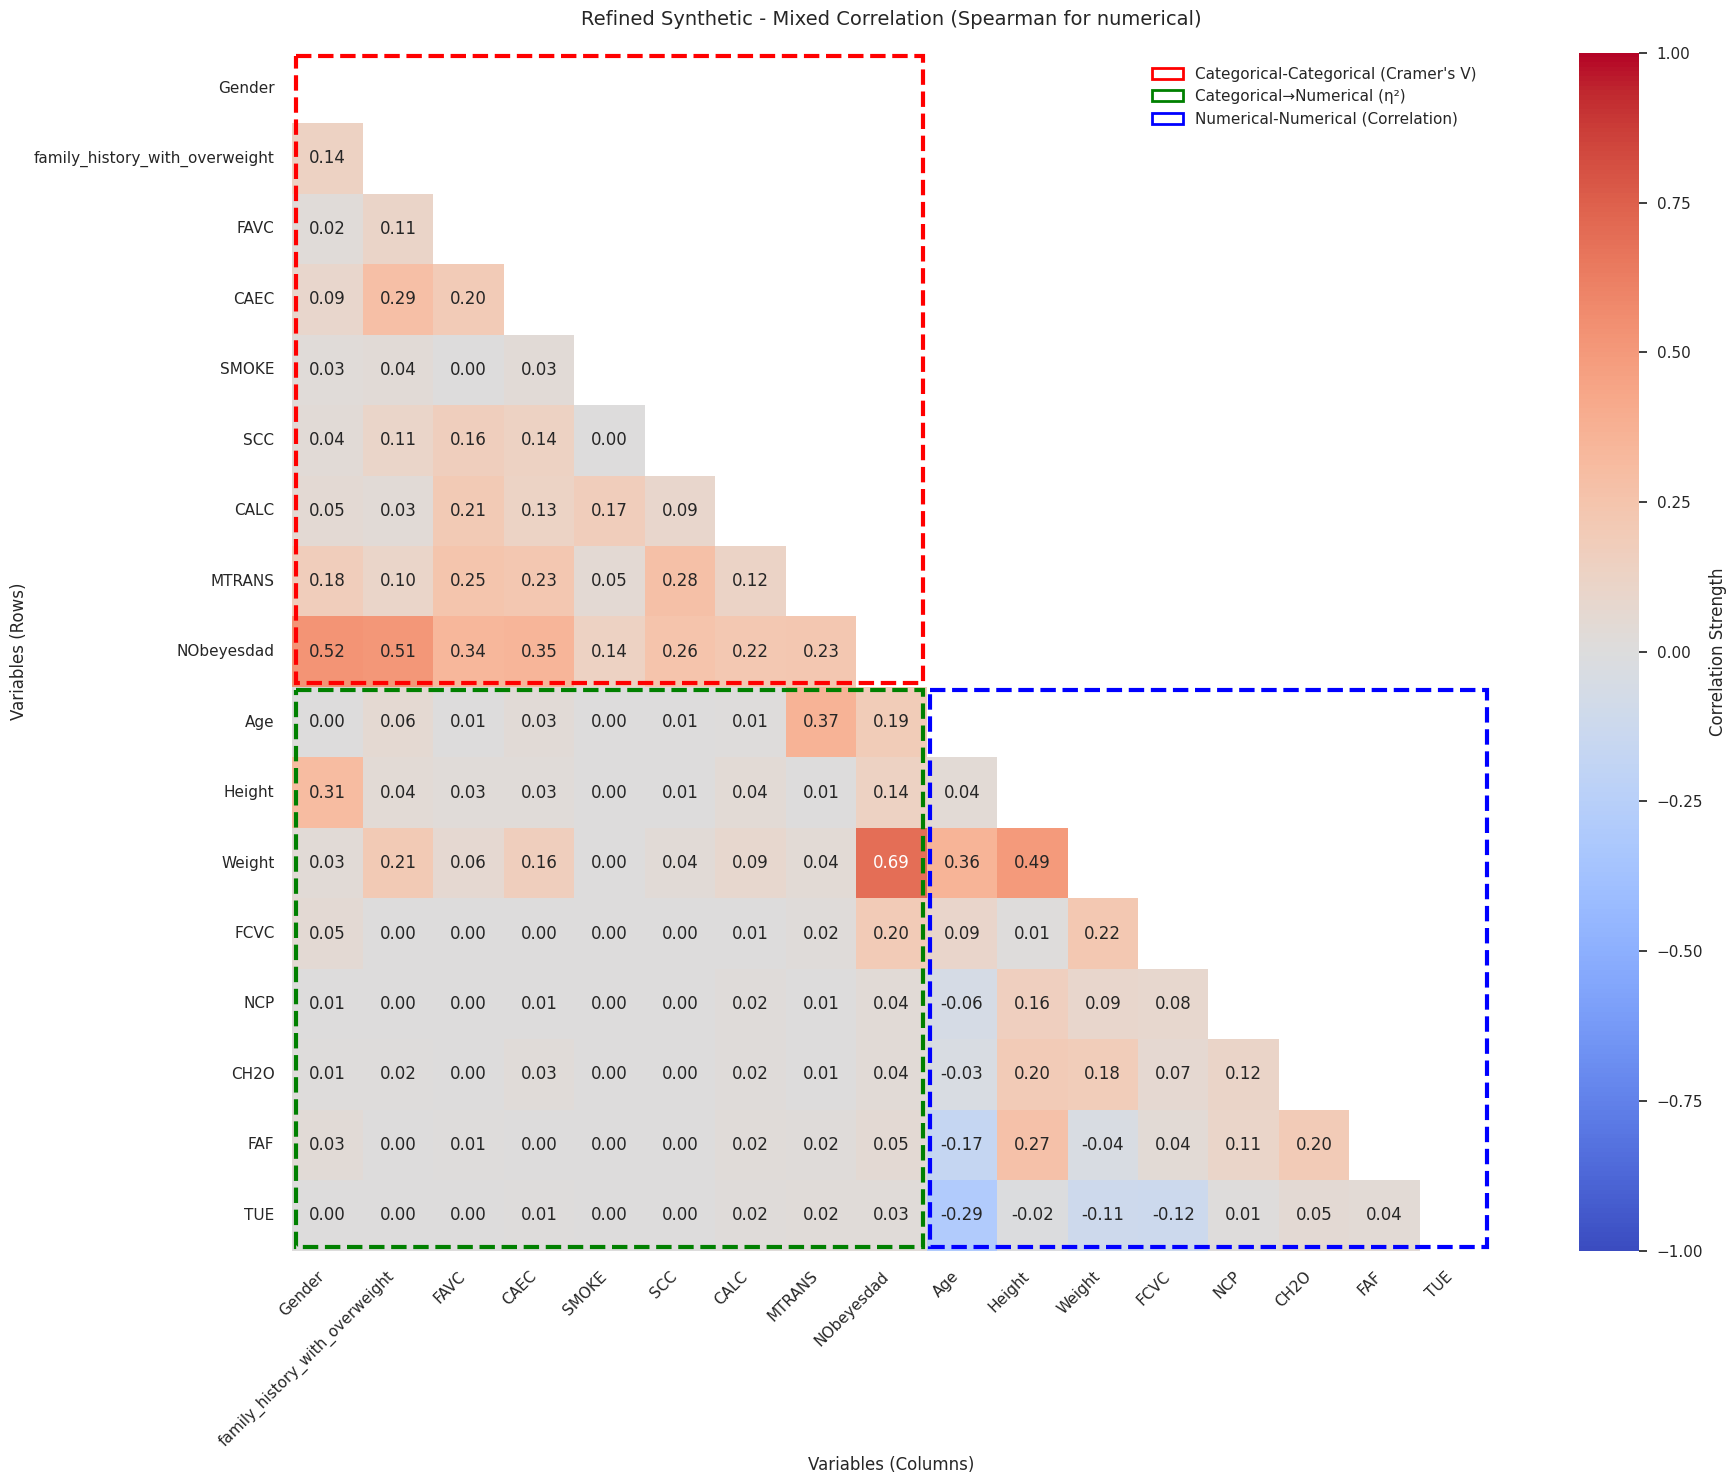

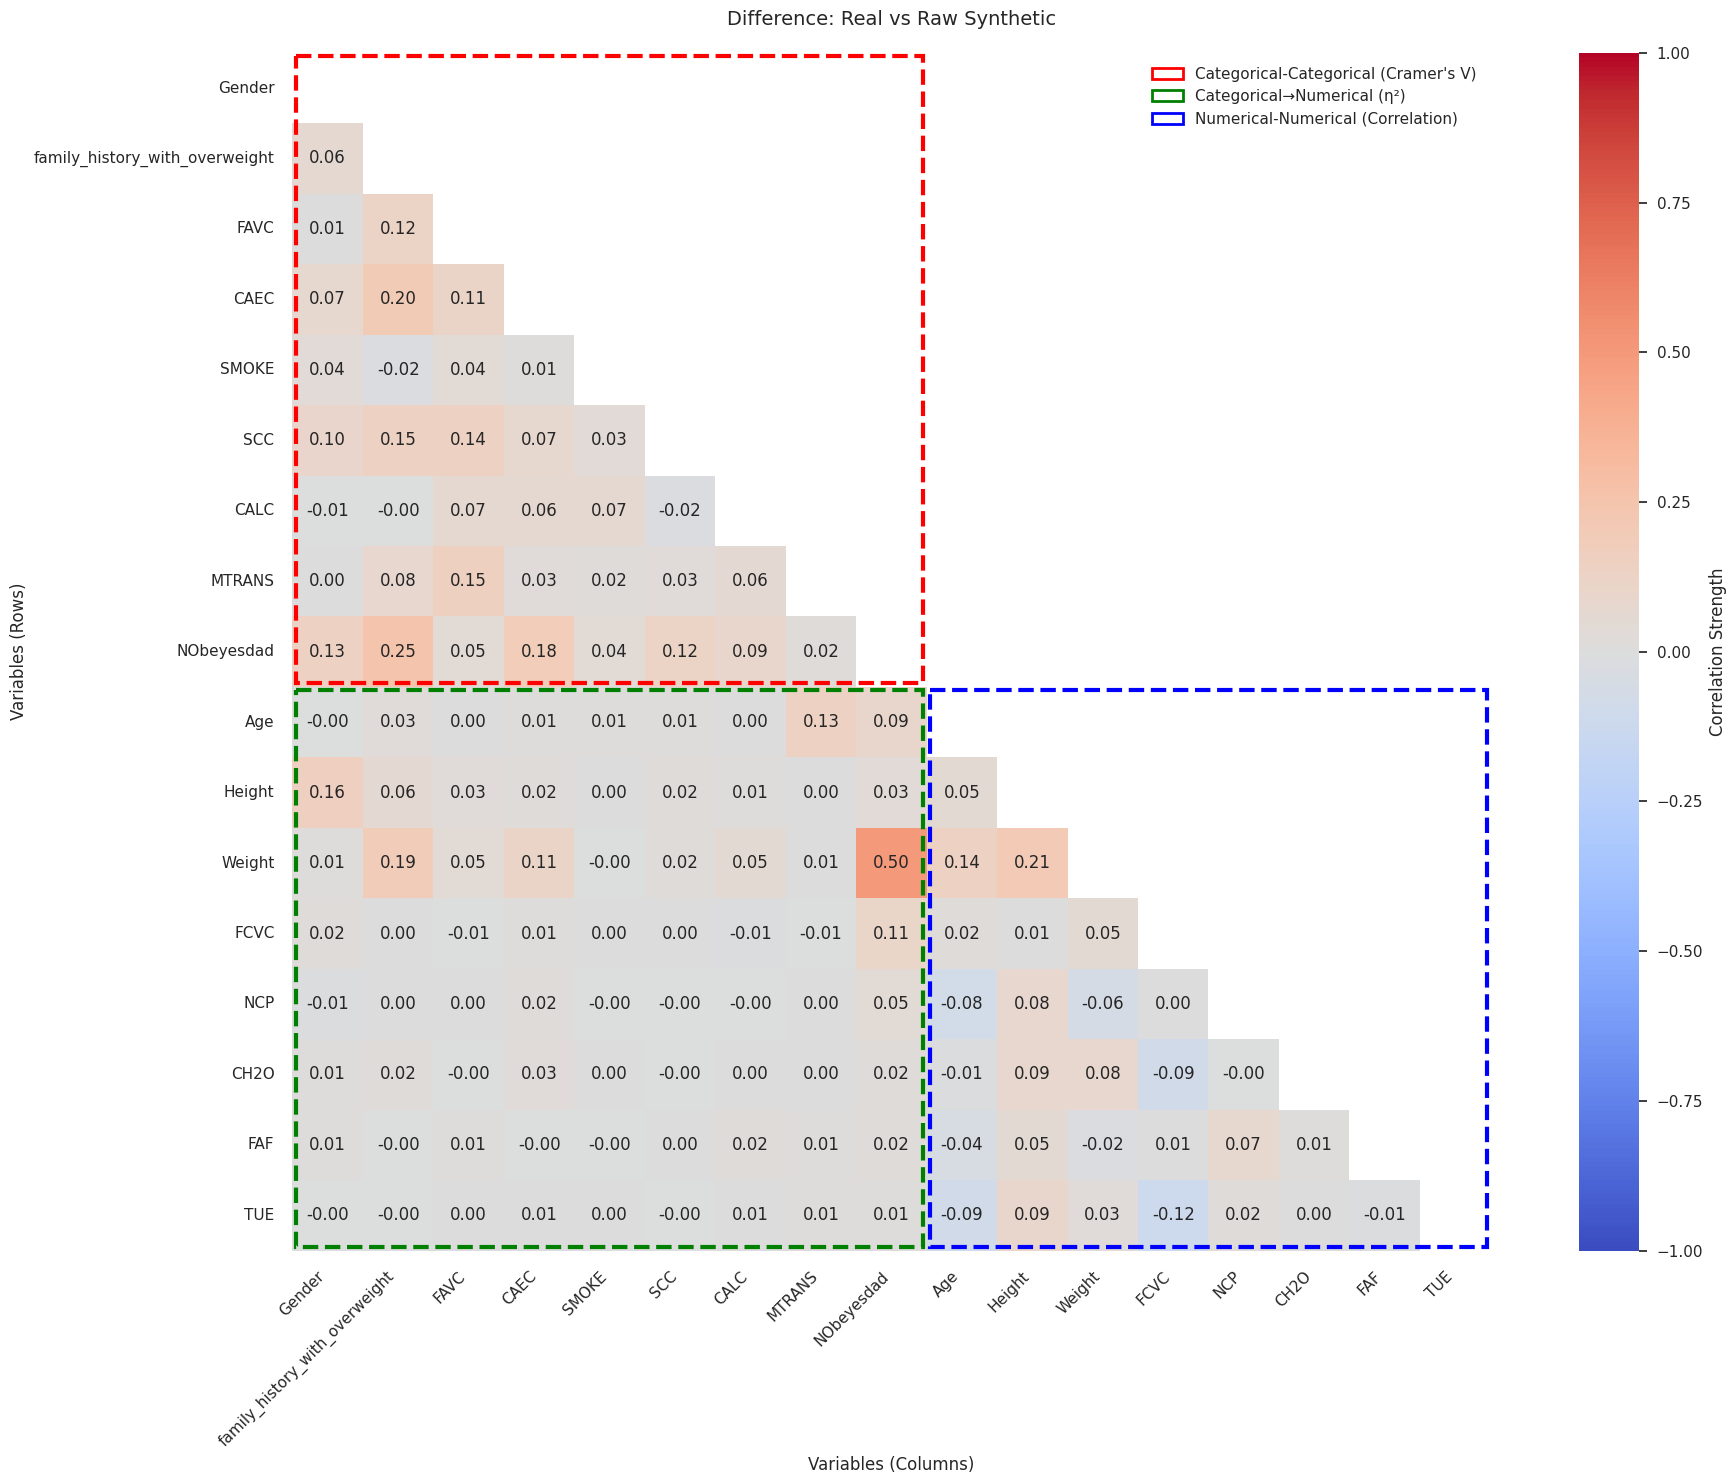

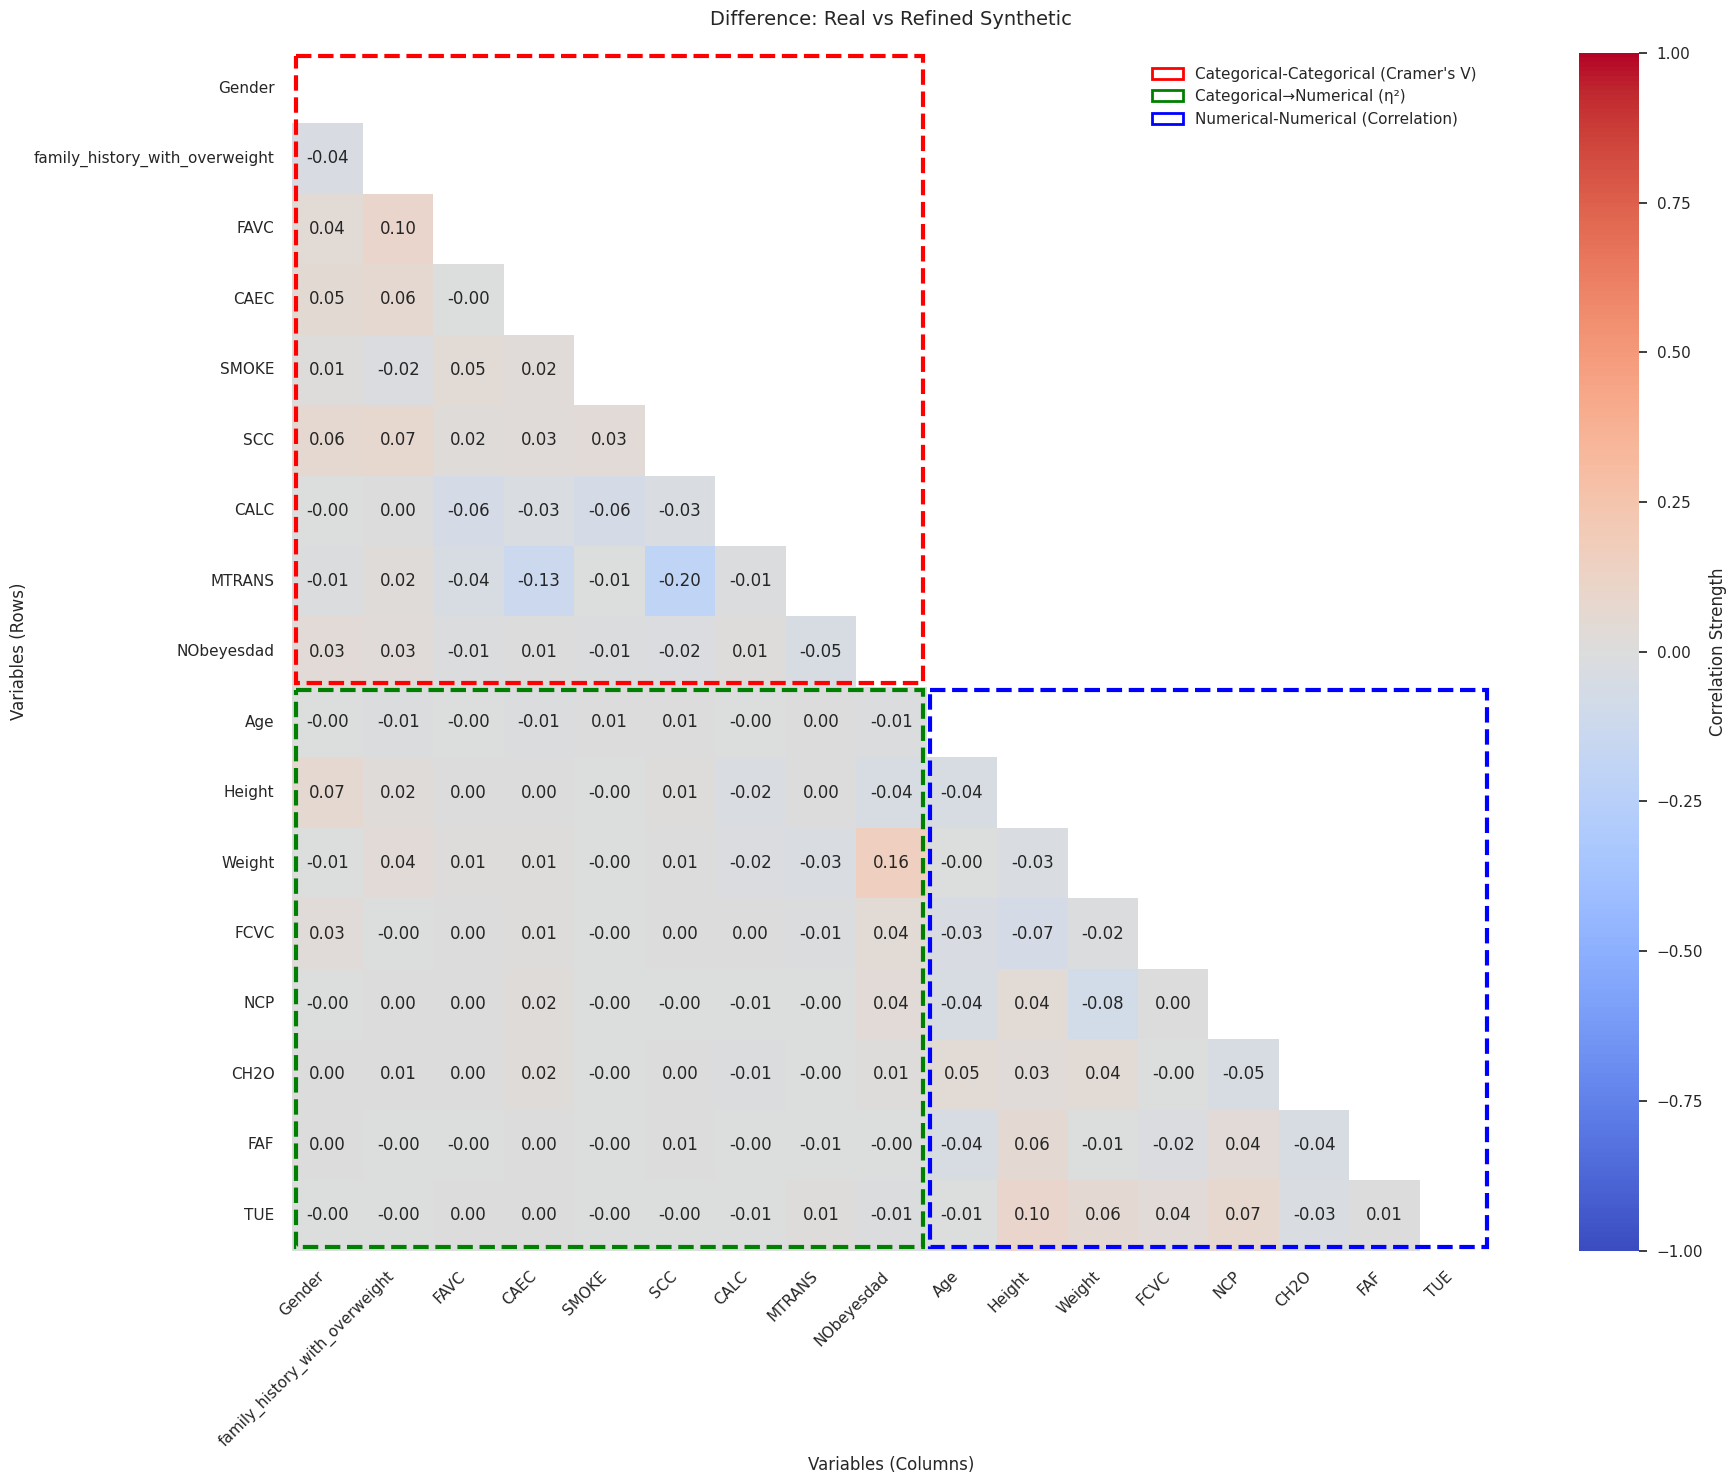

Asymmetric analysis complete! Lower triangle display resolves correlation ratio asymmetry.
Consensus improvement: 48.2% ± 2.7%


In [17]:
from maps.utils.CorrAnalyzer import mixed_correlation_analysis
# Use the new robust function
results = mixed_correlation_analysis(
    real_data=real_data,
    raw_synthetic_data=raw_synthetic_data,
    refined_synthetic_data=refined_synthetic_data,
    use_mixed=True,
    detailed_analysis=True,  # This addresses your concern!
    method='spearman',
    figsize = (20,15)
)

    
# Multiple validation scores
consensus_improvement = results['similarity_scores']['consensus_improvement']
consensus_std = results['similarity_scores']['consensus_std']

print(f"Consensus improvement: {consensus_improvement:.1f}% ± {consensus_std:.1f}%")

## Utility test

In [18]:
from maps.core.utility import run_utility_evaluation,plot_evaluation_results,print_summary_table,plot_feature_importance_comparison

ENHANCED UTILITY EVALUATION: TRAIN ON SYNTHETIC, TEST ON REAL
Cross-Validation: All Metrics (Accuracy, F1-Macro, ROC-AUC)
Feature Importance Analysis Included
FIXED: Synthetic datasets properly split to match real training size

Analyzing target classes across datasets...
All unique classes found: ['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I', 'Overweight_Level_II']
Target encoder classes: ['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']

Splitting real data for proper evaluation...
Test size: 20%, CV validation size: 20% of remaining data
Real train set: 1350 samples
Real CV validation set: 338 samples
Real test set: 423 samples

Sampling synthetic datasets to match real training size: 1350 samples
Raw synthetic train set: 1350 samples
Refined synthetic train set: 1350 samples

Preparing real test data...
  Encoded categorica

    Fold 5: Accuracy=0.8657, F1=0.8632, ROC-AUC=0.9785
CV Accuracy: 0.8578 ± 0.0444
CV F1-Macro: 0.8530 ± 0.0496
CV ROC-AUC: 0.9818 ± 0.0072
Test Accuracy: 0.8487
Test F1-Macro: 0.8454
Test ROC-AUC: 0.9799

SCENARIO 3: Train on Real (Train Split), Test on Real (Test Split)
             CV: Train on Real, Validate on Real
             [PROPER BASELINE - NO DATA LEAKAGE]

Evaluating Real (Train) → Real (Test):
  Training data shape: (1350, 16)
  Test data shape: (423, 16)
  Performing standard CV: Train and validate on same data type
CV Accuracy: 0.9444 ± 0.0137
CV F1-Macro: 0.9429 ± 0.0146
CV ROC-AUC: 0.9957 ± 0.0019
Test Accuracy: 0.9433
Test F1-Macro: 0.9437
Test ROC-AUC: 0.9964

FEATURE IMPORTANCE ANALYSIS


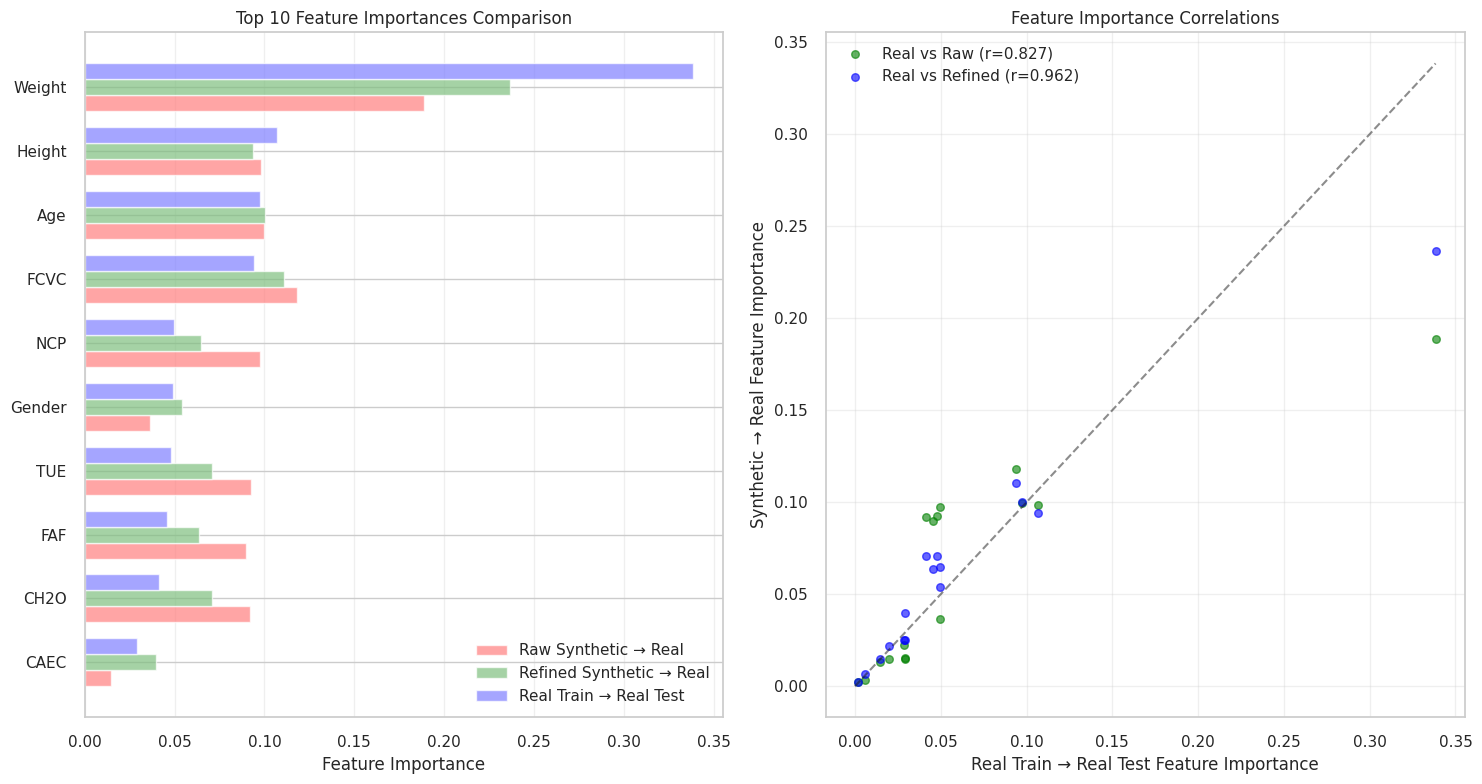


Feature Importance Correlation Analysis:
Real vs Raw Synthetic: 0.8270
Real vs Refined Synthetic: 0.9621

Top 5 Features by Importance:
Raw Synthetic → Real:
  1. Weight: 0.1886
  2. FCVC: 0.1180
  3. Age: 0.0997
  4. Height: 0.0982
  5. NCP: 0.0973

Refined Synthetic → Real:
  1. Weight: 0.2364
  2. FCVC: 0.1107
  3. Age: 0.1003
  4. Height: 0.0939
  5. CH2O: 0.0708

Real Train → Real Test:
  1. Weight: 0.3384
  2. Height: 0.1068
  3. Age: 0.0976
  4. FCVC: 0.0941
  5. NCP: 0.0497



In [19]:
results = run_utility_evaluation(real_data, raw_synthetic_data, refined_synthetic_data, target_column='NObeyesdad', test_size=0.2, random_state=42)

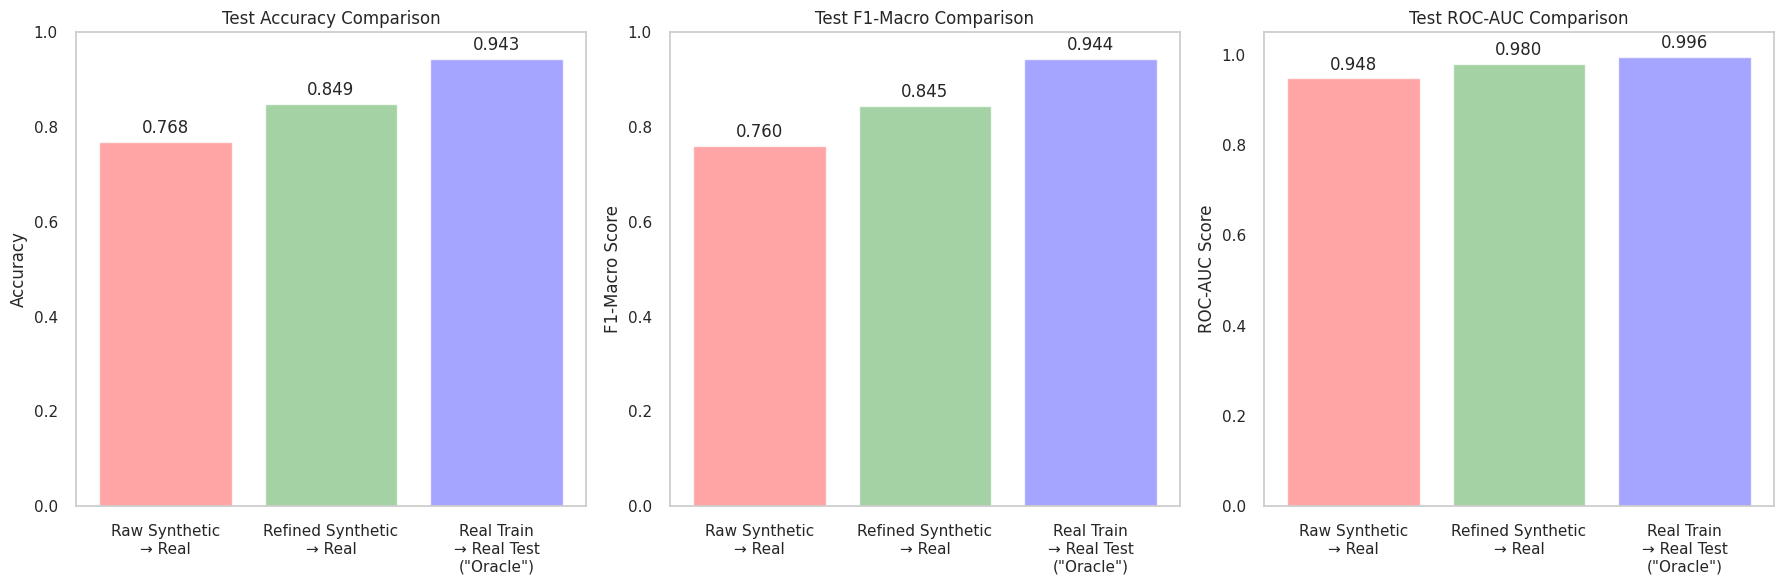

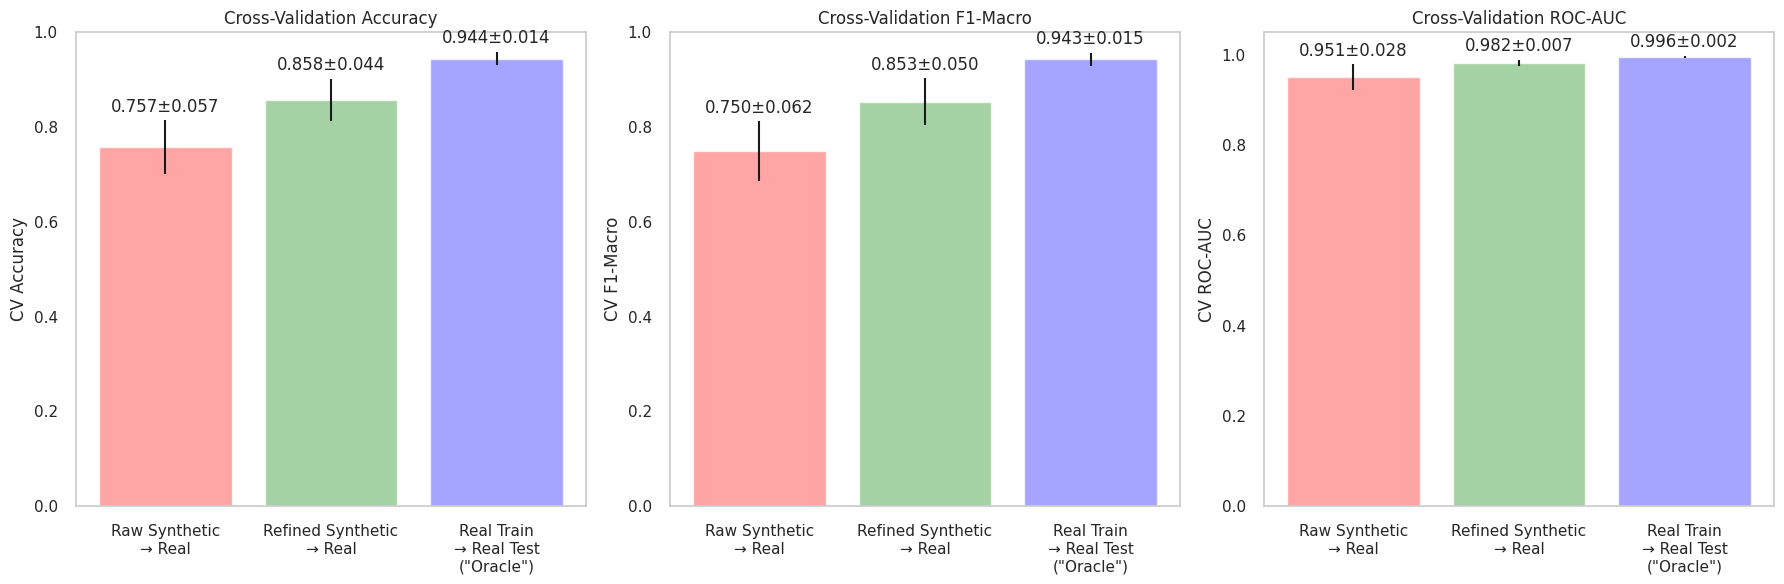


COMPREHENSIVE SUMMARY TABLE
Scenario                       CV Acc       CV F1        CV AUC       Test Acc     Test F1      Test AUC    
------------------------------------------------------------------------------------------------------------------------
Raw Synthetic → Real           0.7574±0.057 0.7497±0.062 0.9510±0.028 0.7683       0.7601       0.9482      
Refined Synthetic → Real       0.8578±0.044 0.8530±0.050 0.9818±0.007 0.8487       0.8454       0.9799      
Real Train → Real Test         0.9444±0.014 0.9429±0.015 0.9957±0.002 0.9433       0.9437       0.9964      

IMPROVEMENT ANALYSIS
Test Accuracy improvement from C-MAPS refinement: +10.46%
Test F1-Macro improvement from C-MAPS refinement: +11.22%
CV Accuracy improvement from C-MAPS refinement: +13.26%

Gap to baseline (Raw Synthetic): 18.55%
Gap to baseline (Refined Synthetic): 10.03%
Refinement reduces gap by: 8.52 percentage points


In [20]:
plot_evaluation_results(results, separate_figures=True, figsize=(5,4))
print_summary_table(results)